# Exploratory Data Analysis (EDA)

Performing exploratory data analysis provided comprehensive insights into the underlying structure and characteristics of the dataset. By analysing the distributions, identifying outliers and correlations between attributes, we uncovered issues in data quality. These insights informed targeted feature engineering strategies, such as encoding and feature selection, ensuring the dataset was optimally structured for subsequent modelling. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import chi2_contingency

# load datasets
applications = pd.read_csv("../data/processed/cleaned_applications.csv") 
credit_records = pd.read_csv("../data/processed/cleaned_credit_records.csv")

### Transforming Numerical Features

The attributes `days_birth` and `days_employed` were originally represented as negative values in days. These were transformed into positive year-based features: `age` and `years_employed`. This provides a more intuitive understanding of the data, making it clearer for both exploratory analysis and downstream modelling. 

In [2]:
# process days_birth to age for better readability
applications['age'] = (-applications['days_birth']) // 365
applications = applications.drop('days_birth', axis=1)

# processand days_employed to years_employed for better readability
applications['years_employed'] = round(-applications['days_employed'].apply(lambda x: x / 365 if x < 0 else -1), 1)
applications = applications.drop('days_employed', axis=1)

applications.head()

,id,gender,own_car,own_realty,num_children,annual_income,income_type,education_type,family_status,housing_type,work_phone,phone,email,occupation,family_size,age,years_employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Others,2.0,32,12.4
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Others,2.0,32,12.4
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3.1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52,8.4
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52,8.4


### Distribution of Numeric Features

All features were classified into numerical variables and categorical variables. The set of numerical features (`annual_income`, `age`, `years_employed`, `family_size`, `num_children`) were visualised through plotting histograms. Attributes `annual_income` and `years_employed`, were found to be highly right skewed. To reduce skewness and stabilize variance, log-transformations were applied, resulting in transformed features `log_annual_income` and `log_years_employed` 

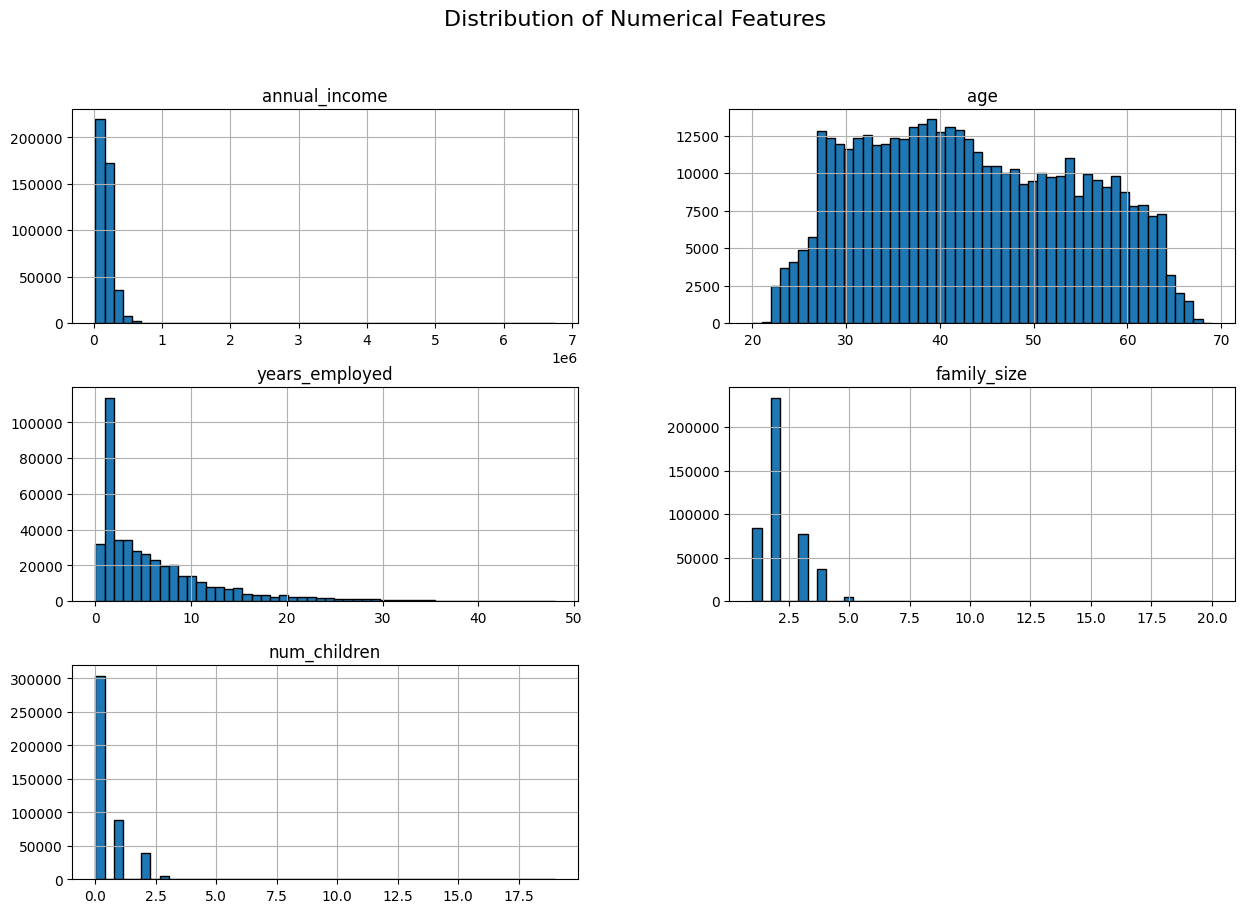

In [3]:
numeric_cols = ['annual_income', 'age', 'years_employed', 'family_size', 'num_children']
binary_cols = ['work_phone', 'phone', 'email']
cat_cols = ['gender', 'own_car', 'own_realty', 'income_type', 'education_type',
            'family_status', 'housing_type', 'occupation']

applications[numeric_cols].hist(figsize = (15, 10), bins = 50, edgecolor = 'black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

Outliers were detected in the attributes `family_size` and `num_children`. To reduce the influence of extreme values during model training, we applied a cap at reasonable maximum values (8 for `family_size` and 6 for `num_children`). These thresholds were chosen by observing natural cutoffs in the histogram distributions and align with realistic assumptions in demographic data. 

In [4]:
applications['log_annual_income'] = np.log1p(applications['annual_income'])
applications['log_years_employed'] = np.log1p(applications['years_employed'])
applications['family_size'] = applications['family_size'].clip(upper=8)
applications['num_children'] = applications['num_children'].clip(upper=6)

### Correlation between Numeric Features

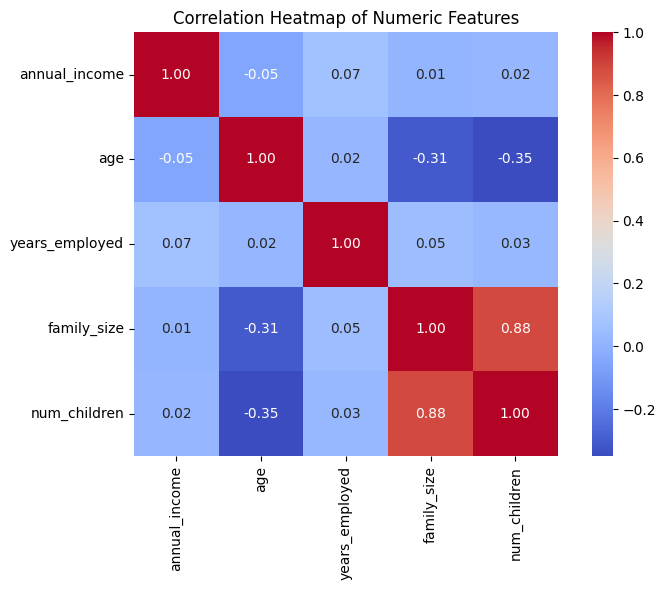

In [5]:
# Compute correlation matrix
corr_matrix = applications[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

Computing a correlation matrix revealed a strong relationship between `num_children` and `family_size`, which had a high correlation coefficient of 0.88. To reduce dimensionality and redundancy, and to prevent multicollinearity, `num_children` was dropped, retaining only `family_size`. 

In [6]:
applications = applications.drop('num_children', axis=1)

### Distribution of Binary Features

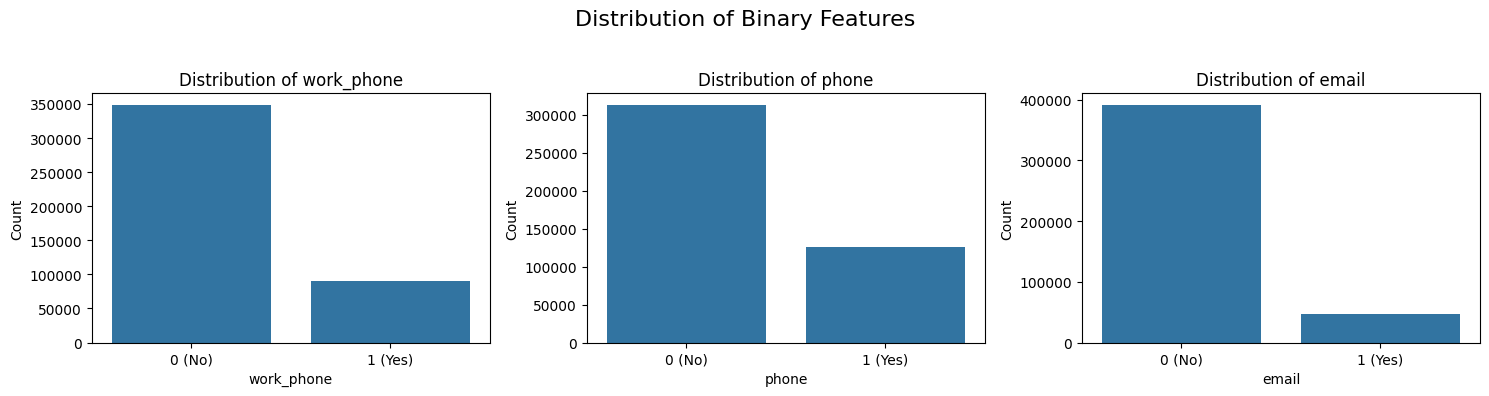

In [7]:
fig, axes = plt.subplots(1, len(binary_cols), figsize=(5 * len(binary_cols), 4))

# If there's only one column, wrap axes in list
if len(binary_cols) == 1:
    axes = [axes]

# Plot bar charts
for i, col in enumerate(binary_cols):
    sns.countplot(data=applications, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['0 (No)', '1 (Yes)'])

plt.suptitle("Distribution of Binary Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Distribution of Categorical Features

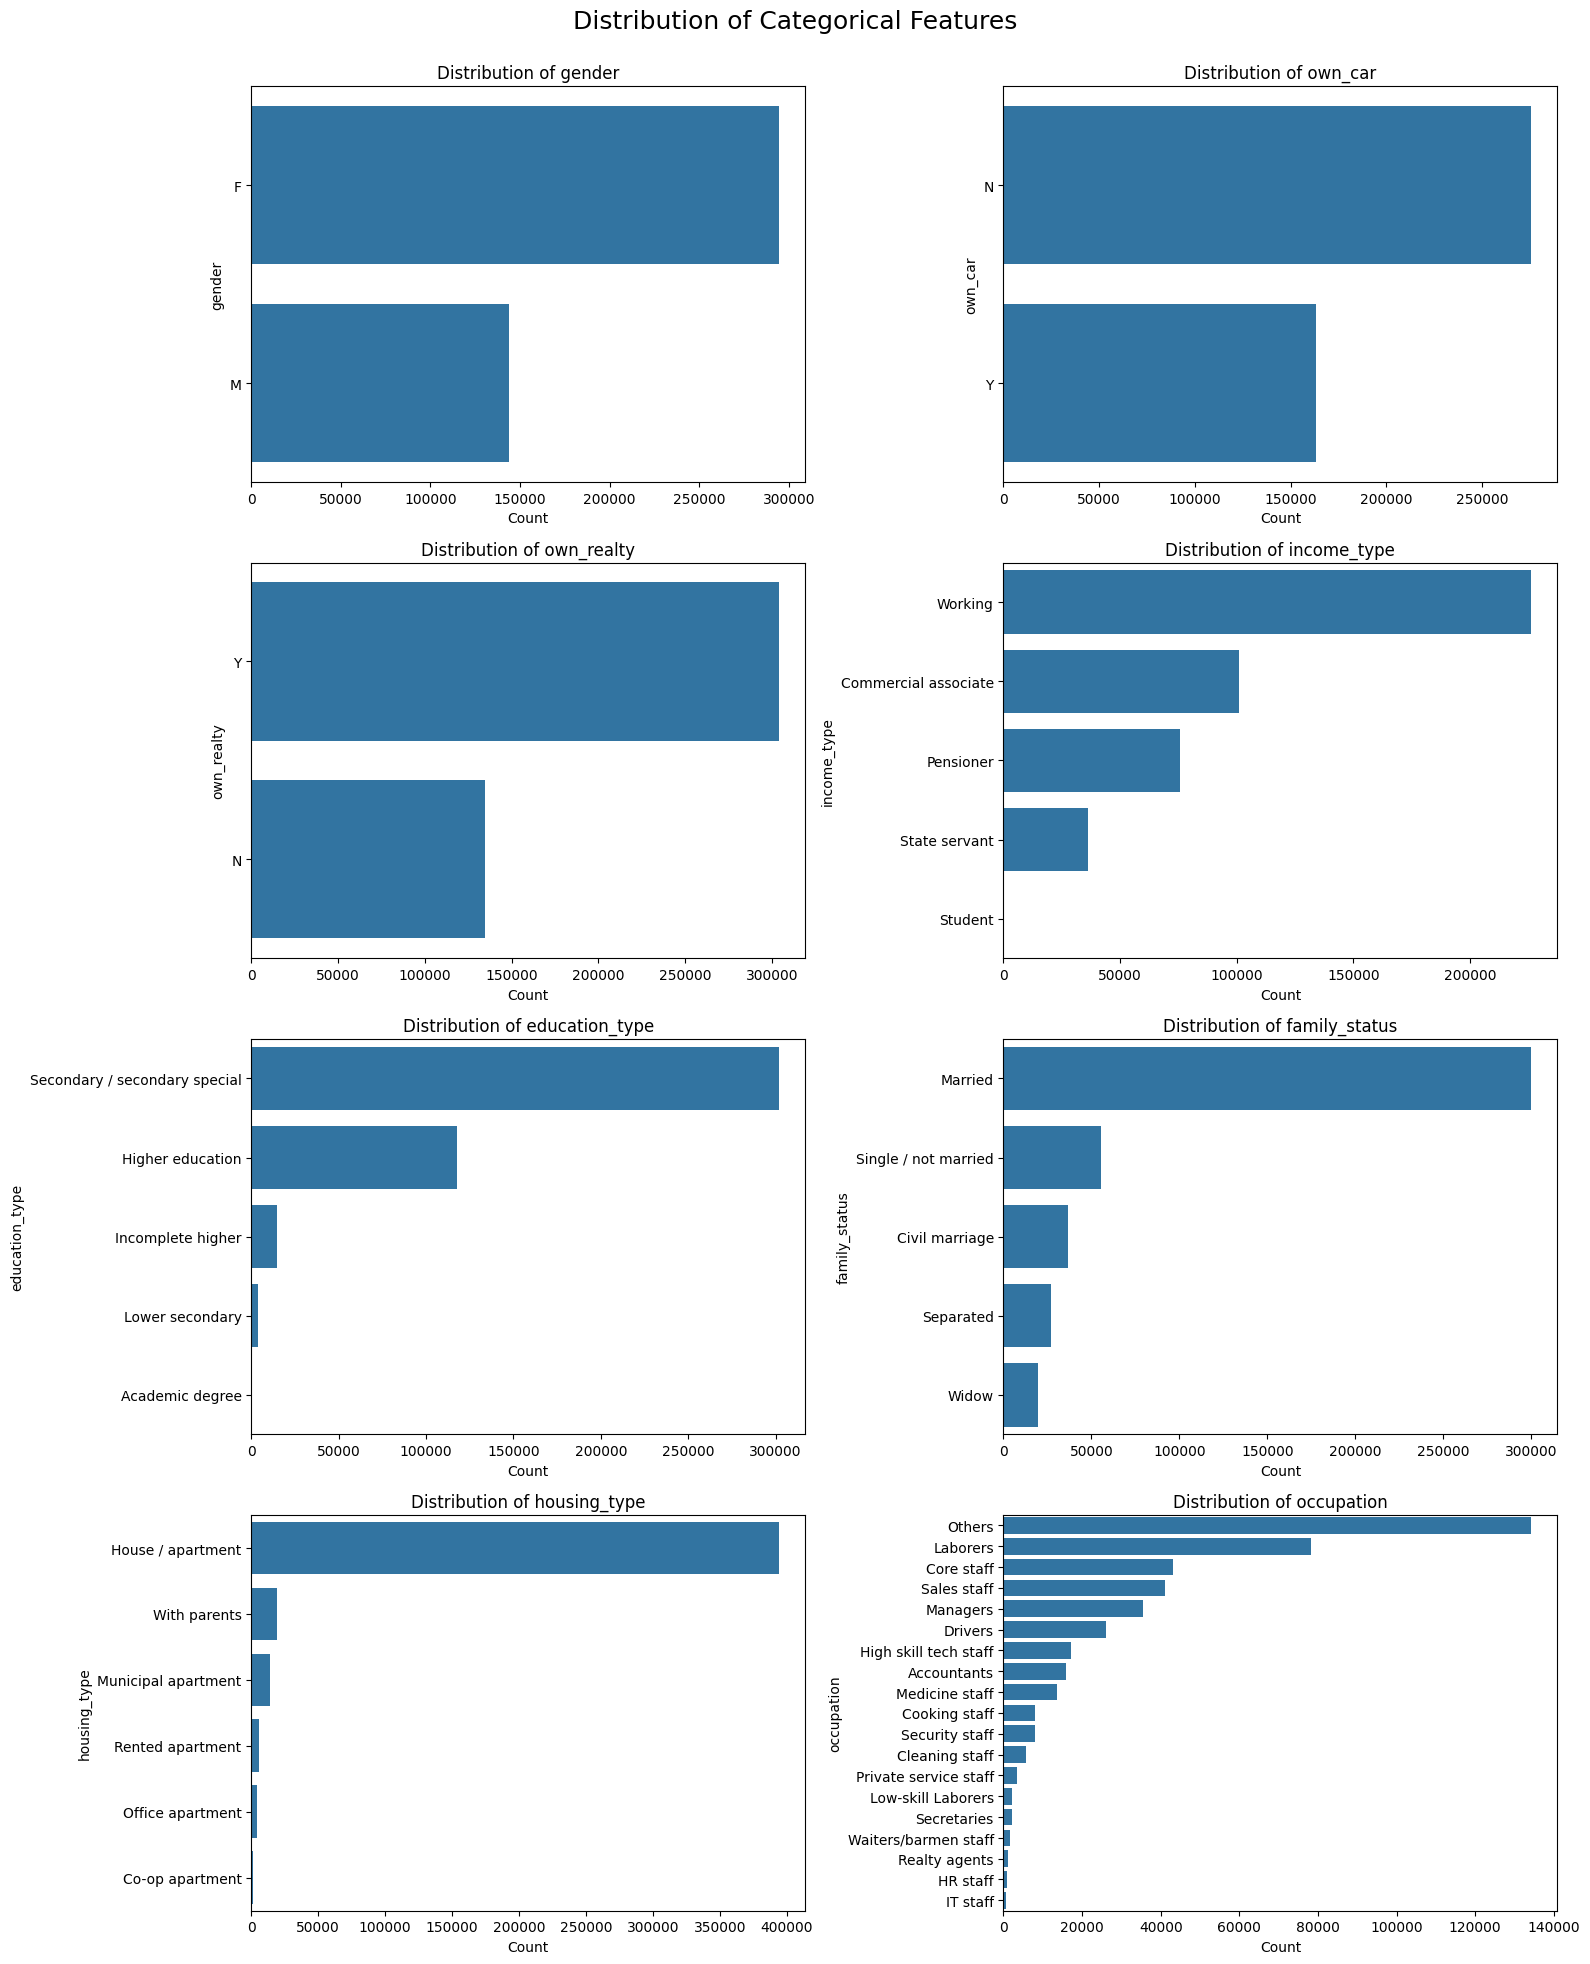

In [8]:
# Fixed grid size
n_cols = 2
n_rows = 4  # since we have 8 features

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))
axes = axes.flatten()

# Generate countplots
for i, col in enumerate(cat_cols):
    sns.countplot(data=applications, y=col, order=applications[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)

# Layout cleanup
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Distribution of Categorical Features", fontsize=18)

plt.show()

## Feature Engineering

### One-hot Encoding

The set of binary features (`work_phone`, `phone`, `email`) are label encoded converting string labels ("Yes"/"No") to binary values (1/0).
The multi-class categorical variables (`income_type`, `education_type`, `family_status`, `housing_type`, `occupation`) are then one-hot encoded with the first category dropped to prevent multicollinearity (i.e., the dummy variable trap). This transformation preserves the information in each category while converting them into numerical inputs.

In [9]:
pd.set_option('future.no_silent_downcasting', True)

# binary columns
applications['own_car'] = applications['own_car'].replace({"Y":1, "N":0}).astype(int)
applications['own_realty'] = applications['own_realty'].replace({"Y":1, "N":0}).astype(int)
applications['gender'] = applications['gender'].replace({"M":1, "F":0}).astype(int)

# multi-class columns
applications = pd.get_dummies(applications, columns=["income_type", "education_type", "family_status", "housing_type", "occupation"], drop_first=True)

### Scaling Continuous Features


The continuous variables, `log_annual_income`, `age`, and `log_years_employed` had their values scaled using MinMaxScaler. This normalised their range between 0 and 1, ensuring consistent weight across features in distance-based models. 

In [10]:
continuous_features = ['log_annual_income', 'age', 'log_years_employed']

# Scale values between 0 and 1
scaler = MinMaxScaler()
applications[continuous_features] = scaler.fit_transform(applications[continuous_features])

### Flatten the status dataset
The `status` attribute in the credit record dataset captured monthly loan repayment behaviour using categorical values such as "C" (loan paid), "X" (no active loan), and numeric strings like "0" to "5" representing increasing levels of late payment severity. To make this information usable for analysis and clustering, we converted the sequential credit history into a single row of summary statistics for each user. 

A severity score was assigned to each late payment status to reflect the degree of delinquency. This transformation produced a flattened version of the credit dataset, enabling it to be used in response variable labelling through KMeans. 

In [11]:
# assign a numerical severity level to late payments
status_mapping = {
    "0": 1, # on time
    "1": 2, # 1 month late
    "2": 3, # 2 months late
    "3": 4, 
    "4": 5,  
    "5": 6, # 5+ months late
}

credit_records["status_numeric"] = credit_records["status"].map(status_mapping)


# for each user, 
# - count how many months they paid off loans (C)
# - count how many months they had no loans (X)
# - sum the severity of all late months (status_numeric)

def sum_of_status(record):
    total_paid = (record['status'] == 'C').sum() 
    total_no_loans = (record['status'] == 'X').sum()
    sum_months_late = record['status_numeric'].dropna().sum()

    return pd.Series({
        'total_paid': total_paid,
        'total_no_loans': total_no_loans,
        'sum_months_late': sum_months_late #sum late payment months
    })

user_status_summary = (
    credit_records
    .drop(columns="id")
    .groupby(credit_records["id"])
    .apply(sum_of_status)
    .reset_index()
)
user_status_summary.head()

,id,total_paid,total_no_loans,sum_months_late
0,5001711,0.0,1.0,3.0
1,5001712,9.0,0.0,10.0
2,5001713,0.0,22.0,0.0
3,5001714,0.0,15.0,0.0
4,5001715,0.0,60.0,0.0


### Merge the datasets

In [12]:
merged_df = applications.merge(user_status_summary, on="id", how="inner")
merged_df

,id,gender,own_car,own_realty,annual_income,work_phone,phone,email,family_size,age,...,occupation_Others,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Waiters/barmen staff,total_paid,total_no_loans,sum_months_late
0,5008804,1,1,1,427500.0,1,0,0,2.0,0.244898,...,True,False,False,False,False,False,False,13.0,1.0,3.0
1,5008805,1,1,1,427500.0,1,0,0,2.0,0.244898,...,True,False,False,False,False,False,False,12.0,1.0,3.0
2,5008806,1,1,1,112500.0,0,0,0,2.0,0.775510,...,False,False,False,False,False,True,False,7.0,16.0,7.0
3,5008808,0,0,1,270000.0,0,1,1,1.0,0.653061,...,False,False,False,True,False,False,False,0.0,3.0,2.0
4,5008809,0,0,1,270000.0,0,1,1,1.0,0.653061,...,False,False,False,True,False,False,False,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,315000.0,0,0,0,2.0,0.551020,...,False,False,False,False,False,False,False,0.0,8.0,23.0
36453,5149834,0,0,1,157500.0,0,1,1,2.0,0.265306,...,False,False,False,False,False,False,False,5.0,0.0,72.0
36454,5149838,0,0,1,157500.0,0,1,1,2.0,0.265306,...,False,False,False,False,False,False,False,14.0,0.0,72.0
36455,5150049,0,0,1,283500.0,0,0,0,2.0,0.591837,...,False,False,False,True,False,False,False,0.0,0.0,13.0


## Response Variable Labelling: KMeans Clustering

Since the dataset lacked a response variable, we used KMeans Clustering to group the customers based on attributes likely to impact creditworthiness — annual income, number of paid loans, total number of loans, lateness of loan payments. Using the elbow method, we identified 8 as the optimal number of clusters.

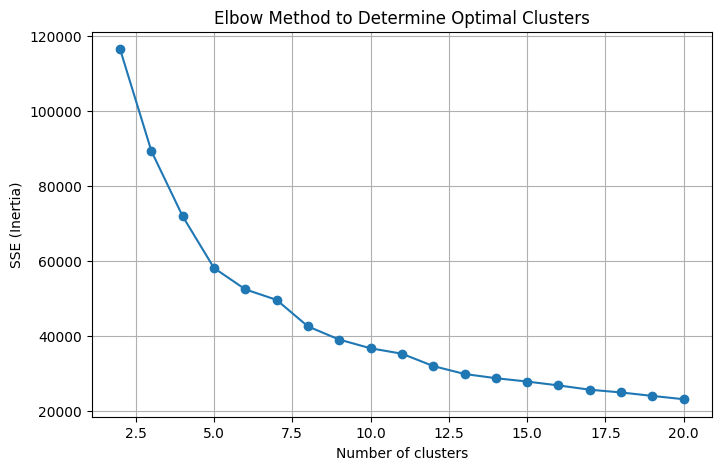

In [13]:
# Select features for clustering
kmeans_features = merged_df[["annual_income", "total_paid", "total_no_loans", "sum_months_late"]]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(kmeans_features)

# Find optimal number of clusters using the Elbow Method
error = []
for i in range(2, 21):  # trying 2 to 20 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(scaled_features)
    error.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), error, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.show()

In [14]:
# Apply KMeans with k = 8
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(scaled_features)

# Inspect cluster behavior
cluster_summary = merged_df.groupby('cluster')[["annual_income", "total_paid", "total_no_loans", "sum_months_late"]].mean()
print(cluster_summary)

         annual_income  total_paid  total_no_loans  sum_months_late
cluster                                                            
0        128133.949851    3.559284        1.384016         6.658054
1        563421.292228    6.541969        3.538860         9.870466
2        177935.680195    1.861111       18.346320         4.153680
3        181820.613451    3.758014        2.058454        29.964488
4        172110.705582   31.845140        1.000425         7.614197
5        187630.434783    3.217391        4.043478       196.739130
6        263056.254632    4.183563        1.582716         7.128242
7        192212.736661    0.651463       40.448365         1.668675


To visualise these clusters, we apply Principle Component Analysis (PCA) to reduce the dimensionality of the feature space.

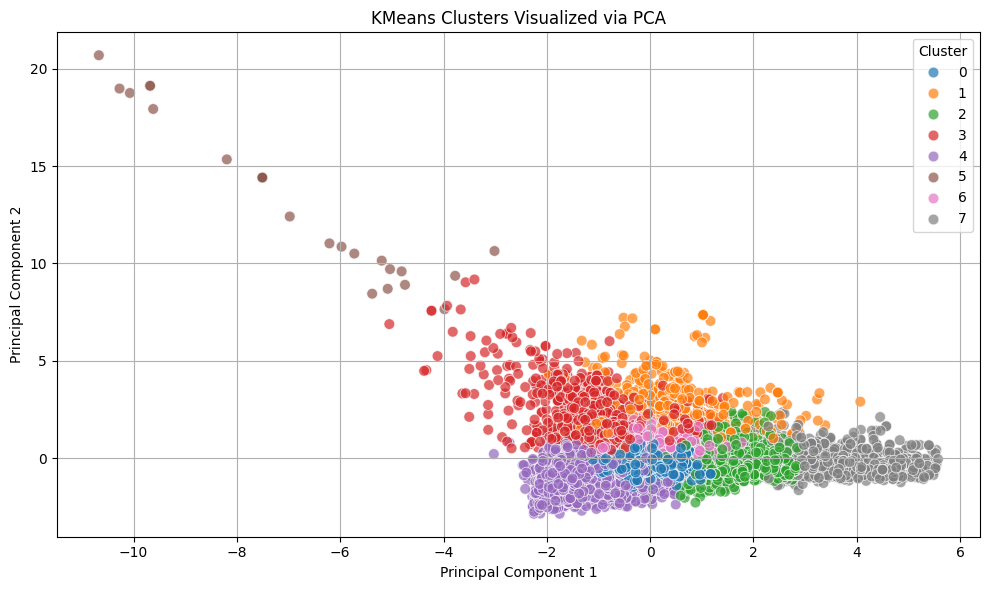

In [15]:
# Reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to dataframe
merged_df['PCA1'] = pca_result[:, 0]
merged_df['PCA2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',
    data=merged_df,
    alpha=0.7,
    s=60
)
plt.title("KMeans Clusters Visualized via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

Banks are less likely to approve credit card approvals for customers who have:
- a high number of late payments (`sum_months_late`)
- a low number of timely payments (`total_paid`)
- lower incomes (`annual_income`)

Therefore, clusters 3 and 5 may contain individuals who are more likely to default, or have poor credit behaviour.


In [16]:
merged_df['credit_status'] = merged_df['cluster'].apply(lambda x: "Bad" if x in [3, 5] else "Good")
merged_df = merged_df.drop(columns=["annual_income", "years_employed", "cluster", "sum_months_late", "total_paid", "total_no_loans"])
merged_df

,id,gender,own_car,own_realty,work_phone,phone,email,family_size,age,log_annual_income,...,occupation_Others,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Waiters/barmen staff,PCA1,PCA2,credit_status
0,5008804,1,1,1,1,0,0,2.0,0.244898,0.503298,...,True,False,False,False,False,False,False,-0.068444,0.719020,Good
1,5008805,1,1,1,1,0,0,2.0,0.244898,0.503298,...,True,False,False,False,False,False,False,-0.025477,0.755218,Good
2,5008806,1,1,1,0,0,0,2.0,0.775510,0.262989,...,False,False,False,False,False,True,False,1.125939,-0.478228,Good
3,5008808,0,0,1,0,1,1,1.0,0.653061,0.420579,...,False,False,False,True,False,False,False,0.607528,0.295636,Good
4,5008809,0,0,1,0,1,1,1.0,0.653061,0.420579,...,False,False,False,True,False,False,False,0.851317,0.151752,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,0,0,0,2.0,0.551020,0.448327,...,False,False,False,False,False,False,False,0.264974,1.951359,Bad
36453,5149834,0,0,1,0,1,1,2.0,0.265306,0.323556,...,False,False,False,False,False,False,False,-2.555084,4.336667,Bad
36454,5149838,0,0,1,0,1,1,2.0,0.265306,0.323556,...,False,False,False,False,False,False,False,-2.941784,4.010879,Bad
36455,5150049,0,0,1,0,0,0,2.0,0.591837,0.429361,...,False,False,False,True,False,False,False,-0.051281,1.129798,Good


### Distribution of Response Variable (credit_status) 

Ratio ('Good' / 'Bad'): 10.375


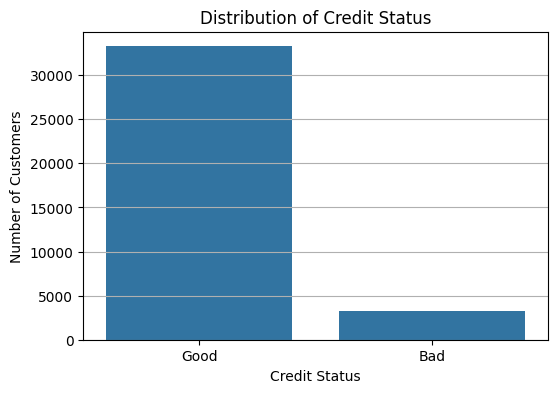

In [17]:
status_counts = merged_df['credit_status'].value_counts()

# Calculate ratio
ratio = round(status_counts.max() / status_counts.min(), 4)
print(f"Ratio ('Good' / 'Bad'): {ratio}")

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title("Distribution of Credit Status")
plt.ylabel("Number of Customers")
plt.xlabel("Credit Status")
plt.grid(axis='y')
plt.show()

### SMOTE

After labelling the response variable, we identified a class imbalance —`credit_status` = “Bad” was severely underrepresented (ratio of 1:10). To address this, we first split the data into training and test sets to prevent data leakage, then applied SMOTE on the training set to up-sample the minority class. 

In [18]:
# Split into train and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df["credit_status"])
# Save the test set
test_path = "../data/processed/test_set.csv"
test_df.to_csv(test_path, index=False)

# Save original training set before SMOTE
train_path = "../data/processed/train_set.csv"
train_df.to_csv(train_path, index=False)

# Split features and label
x_train = train_df.drop(columns=["id", "credit_status"])
y_train = train_df["credit_status"]

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


print(Counter(y_train_resampled))


train_resampled_df = pd.concat(
    [pd.DataFrame(x_train_resampled, columns=x_train.columns),
     pd.Series(y_train_resampled)],
    axis=1)

train_resampled_df

Counter({'Good': 26601, 'Bad': 26601})


,gender,own_car,own_realty,work_phone,phone,email,family_size,age,log_annual_income,log_years_employed,...,occupation_Others,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Waiters/barmen staff,PCA1,PCA2,credit_status
0,0,0,0,0,1,0,3.0,0.204082,0.171038,0.178104,...,False,False,False,True,False,False,False,2.384491,-0.297637,Good
1,0,0,1,0,1,0,3.0,0.469388,0.585518,0.403055,...,False,False,False,True,False,False,False,0.929271,2.530813,Good
2,0,0,0,0,0,0,2.0,0.571429,0.347592,0.878182,...,False,False,False,False,False,False,False,0.228699,-0.024830,Good
3,0,1,0,0,0,0,3.0,0.326531,0.485382,0.537503,...,False,False,False,False,False,False,False,-0.444098,0.886871,Good
4,0,1,0,1,0,1,1.0,0.122449,0.460746,0.151031,...,True,False,False,False,False,False,False,-1.632105,-0.347768,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53197,0,0,0,0,0,0,2.0,0.551020,0.323556,0.575748,...,False,False,False,False,False,False,False,-1.047520,1.699284,Bad
53198,1,1,1,0,1,0,2.0,0.585922,0.314977,0.511861,...,False,False,False,False,False,False,False,-0.951306,1.547106,Bad
53199,1,0,0,0,0,0,2.0,0.558357,0.323192,0.642567,...,False,False,False,False,False,False,False,-1.015301,0.843425,Bad
53200,0,0,1,0,1,0,2.0,0.887794,0.333333,0.178104,...,True,False,False,False,False,False,False,-0.635345,0.836224,Bad


In [19]:
train_resampled_df.to_csv("../data/processed/train_set_SMOTEd.csv", index=False)